In [3]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
from explainabilityModels import make_gradcam_heatmap as GradCam

In [4]:
N = 4000
size = 64
labels = np.random.randint(2, size = N)
imgs = np.zeros((size, size, N))


In [5]:
#fill array with corresponding images
for i in range(N):
    if labels[i] == 0:
        x = generator.generate_blob_img(length=size, big = True, big_blob_size=8, big_blob_range=2)
    elif labels[i] == 1:
        x = generator.generate_blob_img(length=size, big = False)
    imgs[:,:,i] = x

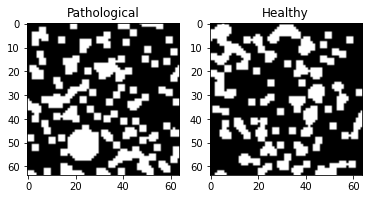

In [6]:
#display one pathological and one healthy image
fig, ax = plt.subplots(1,2)

path_img = imgs[:,:,np.where(labels == 0)[0][0]]
healthy_img = imgs[:,:,np.where(labels ==1)[0][0]]

ax[0].imshow(path_img, cmap=plt.cm.gray)
ax[1].imshow(healthy_img, cmap=plt.cm.gray)

ax[0].set_title("Pathological");
ax[1].set_title("Healthy");


In [10]:
#make gradcam heatmap for every image and normalise
heatmaps = np.zeros_like(imgs)
model = tf.keras.models.load_model("models/model20/")

for img in range(N):
    heatmaps[:,:,img] = GradCam(imgs[:,:,img], model, -5, 0)
    heatmaps[:,:,img] /= heatmaps[:,:,img].sum()


In [11]:
#get segmentation for every image
region_imgs = np.zeros_like(imgs, dtype=np.int64)

for img in range(N):
    region_imgs[:,:,img] = measure.label(imgs[:,:,img])

In [12]:
#find number of blobs in all images
num_blobs_array = []
for img in range(N):
    num_blobs_array.append(np.unique(region_imgs[:,:,img]).shape[0] - 1)

num_blobs = sum(num_blobs_array)
num_blobs

173091

In [13]:
#generate interpretability scores for each blob; score is the sum of intensities of heatmap in the region
scores = np.zeros(num_blobs)
i = 0
for img in range(N):
    for region in np.unique(region_imgs[:,:,img]):
        if region != 0:
            x = np.copy(region_imgs[:,:,img])
            x[x != region] = 0
            scores[i] = (heatmaps[:,:,img] * x).sum()
            i += 1

In [14]:
blob_areas = []
for img in range(N):
    areas = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['area'])).to_numpy().squeeze()
    blob_areas += areas.tolist()

blob_areas = np.asarray(blob_areas)
blob_areas.shape

(173091,)

In [15]:
import plotly
import plotly.express as px

df = pd.DataFrame(data=np.vstack((scores, blob_areas)).T, columns=['score', ' area'])
px.scatter(data_frame=df, x = df.columns[0], y = df.columns[1])


In [23]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.expand_dims(scores, -1)
y = blob_areas

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)





In [24]:
#build regression tree
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

Text(0.5, 1.0, 'Test Set')

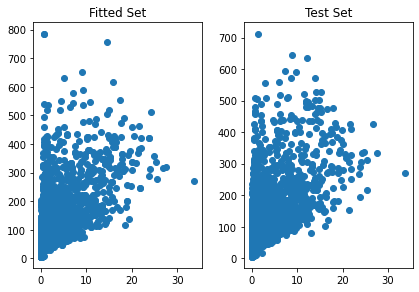

In [32]:
fig, ax = plt.subplots(1,2)
fig.tight_layout()
pred = regressor.predict(X_test)
ax[0].scatter(X_test, pred)
ax[0].set_title("Fitted Set")
ax[1].scatter(X_test, y_test)
ax[1].set_title("Test Set")

In [38]:
#visualize regression tree
from sklearn.tree import export_graphviz
export_graphviz(regressor, out_file='tree.png', feature_names=['area'])


'dot' is not recognized as an internal or external command,
operable program or batch file.


In [43]:
import pydot
(tree,) = pydot.graph_from_dot_file('tree.dot')

KeyboardInterrupt: 